In [95]:
import heapq
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics

# Load the data

In [112]:
source_corpus = []
source_labels = []
files = [
    'kamerstukken_topics-multi_20120101_20120630.json',
    'kamerstukken_topics-multi_20130101_20130630.json',
    'kamerstukken_topics-multi_20140101_20141231.json',
    'kamerstukken_topics-multi_20160602_20161201.json',
    'kamerstukken_topics-multi_20160101_20160601.json',
    'kamerstukken_topics-multi_20170101_20170301.json',
    'kamerstukken_topics-multi_20170302_20170601.json',
    'kamerstukken_topics-multi_20170602_20180101.json',
    'kamerstukken_topics-multi_20180101_20180401.json'
]

for file in files:
    data = json.load(open('../../data_resources/topics/kamerstukken/{}'.format(file)))
    for obj in data:
        if len(obj['categories']) > 0 and 'Antwoord' not in obj['content']:
            source_corpus.append(obj['content'])
            source_labels.append(obj['categories'])


print(len(source_corpus))
print(len(source_labels))

13948
13948


In [131]:
unlabeled_corpus = []
files = [
    'poliflw_target_unlabeled.json'
]

for file in files:
    data = json.load(open('../../data_resources/topics/kamerstukken/{}'.format(file)))
    for obj in data:
        unlabeled_corpus.append(obj['content'])

print(len(unlabeled_corpus))

20000


In [133]:
target_corpus = []
target_labels = []
files = [
    'poliflw_target_labeled_data_checked.json'
]

for file in files:
    data = json.load(open('../../data_resources/topics/kamerstukken/{}'.format(file)))
    for obj in data:
#         source_corpus.append(obj['content'])
#         source_labels.append(obj['categories'])
        
        target_corpus.append(obj['content'])
        target_labels.append(obj['categories'])


print(len(target_corpus))
print(len(target_labels))

167
167


# Define helper functions and constants

In [119]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=2, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    
    
    
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scorer)
    

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    print(train_scores)
    print(np.shape(train_scores_mean))

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [137]:
def pre_process(s):
    result = ''.join([i for i in s if not i.isdigit()])
    return result.upper()

def predict_multi_always(clf, x):
    y_pred = clf.predict(x)
    y_prob = clf.predict_proba(x)
    
    for sample_index in range(0,len(y_pred)):
        most_probable_label = np.where(y_prob[sample_index] == max(y_prob[sample_index]))[0][0]
        y_pred[sample_index][most_probable_label] = 1
        
    return y_pred

def train_clf(corpus, labels):
    transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
    mlb = MultiLabelBinarizer()
    
    X = transformer.fit_transform(corpus)
    y = mlb.fit_transform(labels)
    
    clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
    clf = OneVsRestClassifier(clf).fit(X, y)
    
    return transformer, mlb, clf

def merge_training_data(original_corpus, unlabeled_corpus, original_labels, unlabeled_predictions):
    new_corpus = []
    new_labels = []
    
    for i in range(0,len(original_corpus)):
        new_corpus.append(original_corpus[i])
        new_labels.append(original_labels[i])
        
    for i in range(0,len(unlabeled_predictions)):
        new_corpus.append(unlabeled_corpus[i])
        
        labels = []
        for pred in unlabeled_predictions[i]:
            labels.append(pred)
        new_labels.append(labels)
    
    return new_corpus, new_labels

def evaluate_target_domain(transformer, mlb, clf, corpus, labels):
    X = transformer.transform(corpus)
    y = mlb.transform(labels)
    
    y_pred = predict_multi_always(clf, X)
    
    p = precision_score(y, y_pred, average='micro')
    r = recall_score(y, y_pred, average='micro')
    f1 = f1_score(y, y_pred, average='micro')
    
    print('P,R,F1')
    print(p)
    print(r)
    print(f1)
    
    return [p, r, f1]

# Evaluate initial classifier

In [122]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
mlb = MultiLabelBinarizer()
    
X = transformer.fit_transform(source_corpus)
y = mlb.fit_transform(source_labels)
clf = OneVsRestClassifier(clf).fit(X,y)

In [138]:
evaluate_target_domain(transformer, mlb, clf, target_corpus, target_labels)

P,R,F1
0.3883495145631068
0.35555555555555557
0.3712296983758701


[0.3883495145631068, 0.35555555555555557, 0.3712296983758701]

# Train the classifier
1. Train a classifier on source corpus
2. Classify unlabeled data
3. Add uonlabeled corpus + predictions to labeled data
4. Retrain classifier

In [6]:
t, m, c = train_clf(source_corpus, source_labels)

In [ ]:
y_pred = c.predict(t.transform(unlabeled_corpus))

print(y_pred[0])

In [ ]:
evaluate_target_domain(t, m, c, target_corpus, target_labels)

In [ ]:
t, m, c = train_clf(source_corpus, source_labels)
evaluate_target_domain(t, m, c, source_corpus, source_labels)
evaluate_target_domain(t, m, c, target_corpus, target_labels)

In [70]:
min(100,2)

2

# Soft self-labeling - does not work
Eigenlijk om dit echt om deze manier te testen (met plots) moeten we een soort van crossvalidation doen waarbij we slechts 80% van de data gebruiken. Anders kunnen we lucky zijn.

P,R,F1
0.4954128440366973
0.23893805309734514
0.32238805970149254
#labeled: 13948. #unlabeled: 20000, TOP_N: 2000
19992
P,R,F1
0.35051546391752575
0.1504424778761062
0.21052631578947367


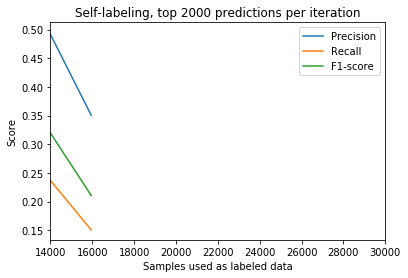

#labeled: 15948. #unlabeled: 18000, TOP_N: 2000
17987
P,R,F1
0.5121951219512195
0.18584070796460178
0.2727272727272727


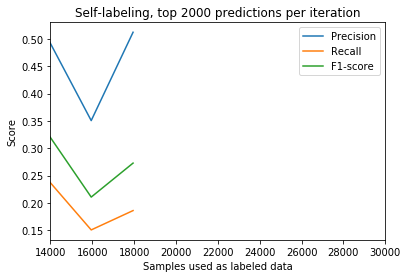

#labeled: 17948. #unlabeled: 16000, TOP_N: 2000
15995
P,R,F1
0.5
0.16371681415929204
0.24666666666666667


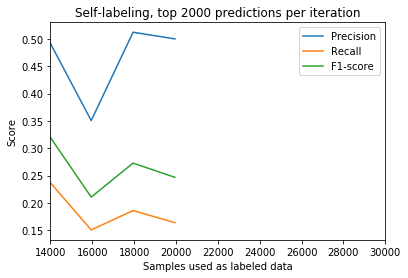

#labeled: 19948. #unlabeled: 14000, TOP_N: 2000
13998
P,R,F1
0.45121951219512196
0.16371681415929204
0.24025974025974028


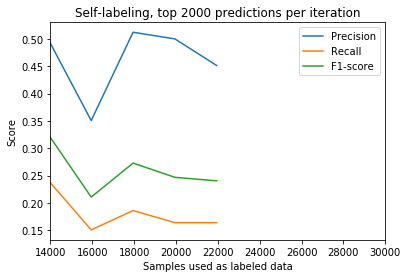

#labeled: 21948. #unlabeled: 12000, TOP_N: 2000
11994
P,R,F1
0.6
0.11946902654867257
0.19926199261992622


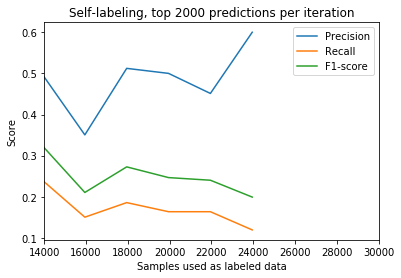

#labeled: 23948. #unlabeled: 10000, TOP_N: 2000
9998
P,R,F1
0.5576923076923077
0.12831858407079647
0.20863309352517986


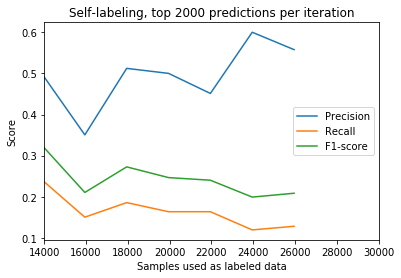

#labeled: 25948. #unlabeled: 8000, TOP_N: 2000
7999
P,R,F1
0.6136363636363636
0.11946902654867257
0.2


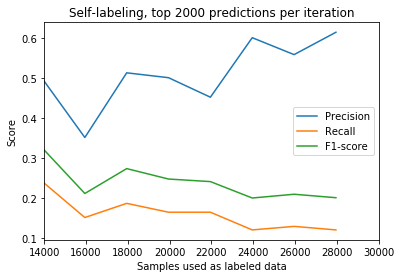

#labeled: 27948. #unlabeled: 6000, TOP_N: 2000
5999
P,R,F1
0.5476190476190477
0.10176991150442478
0.17164179104477612


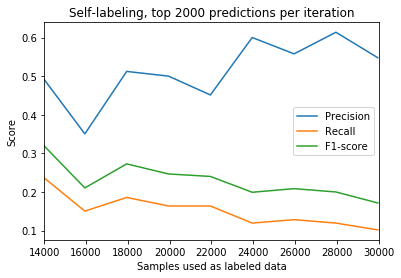

#labeled: 29948. #unlabeled: 4000, TOP_N: 2000
3999
P,R,F1
0.6585365853658537
0.11946902654867257
0.20224719101123598


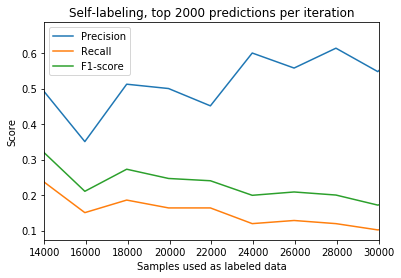

#labeled: 31948. #unlabeled: 2000, TOP_N: 2000
1999
P,R,F1
0.6111111111111112
0.09734513274336283
0.1679389312977099


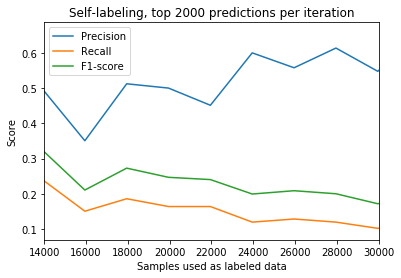

In [111]:
def adapt_domain(step, transformer, mlb, clf, c_labeled_param, l_labeled_param, c_target_param, l_target_param, c_unlabeled_param):
    c_labeled = []
    l_labeled = []
    c_unlabeled = []
    
    for obj in c_labeled_param:
        c_labeled.append(obj)
        
    for obj in l_labeled_param:
        l_labeled.append(obj)
        
    for obj in c_unlabeled_param:
        c_unlabeled.append(obj)
        
    x = []
    py = []
    ry = []
    f1y = []
    
    [p, r, f1] = evaluate_target_domain(transformer, mlb, clf, c_target_param, l_target_param)
        
    x.append(len(c_labeled))
    py.append(p)
    ry.append(r)
    f1y.append(f1)
        
    while len(c_unlabeled) > 0:
    
        TOP_N = min(step, len(c_unlabeled))
    
        print('#labeled: {}. #unlabeled: {}, TOP_N: {}'.format(len(c_labeled), len(c_unlabeled), TOP_N))

        # Get the most certain probability scores on labels.
        y_pred = clf.predict(transformer.transform(c_unlabeled))
        y_probas = clf.predict_proba(transformer.transform(c_unlabeled))
        y_max_probas = []

        for y in y_probas:
            y_max_probas.append(np.max(y))

        y_max_probas = np.array(y_max_probas)
        top_prob_indices = np.array(heapq.nlargest(TOP_N, range(len(y_max_probas)), y_max_probas.take))

        # Add these labels to labeled data (corpus and labels) and remove them from the unlabeled corpus.
        print(max(top_prob_indices))
        for i in top_prob_indices:
            c_labeled.append(c_unlabeled[i])

        for labels in mlb.inverse_transform(y_pred[top_prob_indices]):
            l_labeled.append(labels)

        new_unlabeled = []    
        for i in range(0,len(c_unlabeled)):
            if i not in top_prob_indices:
                new_unlabeled.append(c_unlabeled[i])
        c_unlabeled = new_unlabeled

        # Retrain classifier
    #     print('Retrain classifier')
        t1, m1, c1 = train_clf(c_labeled, l_labeled)

        # Evaluate target domain.
    #     print('Evaluating Target Domain')
        [p, r, f1] = evaluate_target_domain(t1, m1, c1, c_target_param, l_target_param)
        
        x.append(len(c_labeled))
        py.append(p)
        ry.append(r)
        f1y.append(f1)
    
        plt.plot(x, py, label='Precision')
        plt.plot(x, ry, label='Recall')
        plt.plot(x, f1y, label='F1-score')
        plt.xlabel('Samples used as labeled data')
        plt.ylabel('Score')
        plt.xlim(xmax=30000)
        plt.xlim(xmin=14000)
        plt.title('Self-labeling, top {} predictions per iteration'.format(step))
        plt.legend()
        plt.show()
    
    return c1


t, m, c = train_clf(source_corpus, source_labels)

clf_adapted = adapt_domain(2000, t, m, c, source_corpus, source_labels, target_corpus, target_labels, unlabeled_corpus)

# TF-idf on both corpora

0
(13948,)
P,R,F1
0.4954128440366973
0.23788546255506607
0.32142857142857145


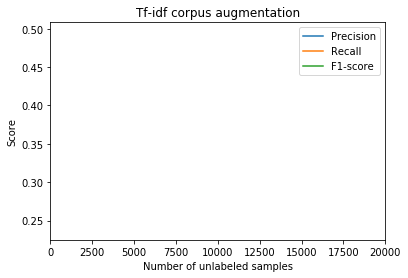

4000
(17948,)
P,R,F1
0.6043956043956044
0.2422907488986784
0.34591194968553457


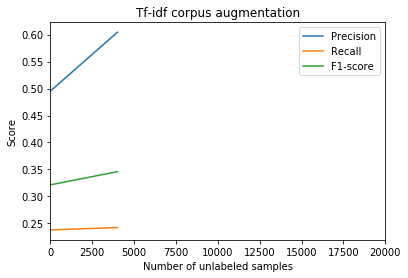

8000
(21948,)
P,R,F1
0.46099290780141844
0.28634361233480177
0.3532608695652174


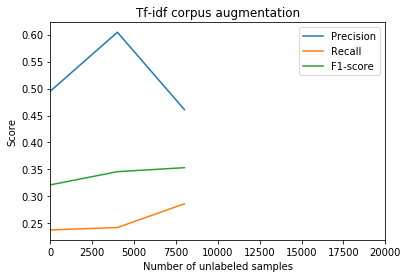

12000
(25948,)
P,R,F1
0.4489795918367347
0.2907488986784141
0.3529411764705882


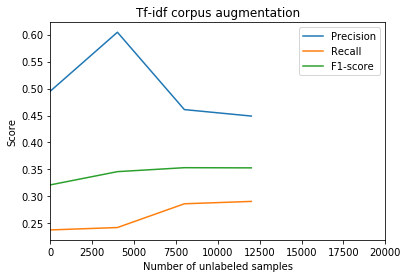

16000
(29948,)
P,R,F1
0.39285714285714285
0.2907488986784141
0.3341772151898734


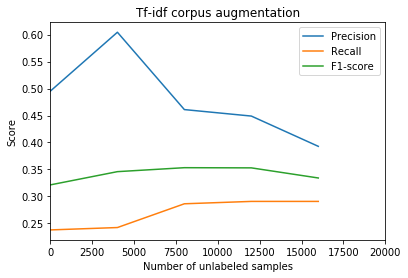

In [99]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
mlb = MultiLabelBinarizer()


x = []
py = []
ry = []
f1y = []

for i in range(0,20000,4000):
    print(i)
    
    tfidf_corpus = []
    for obj in unlabeled_corpus[0:i]:
        tfidf_corpus.append(obj)

    for obj in source_corpus:
        tfidf_corpus.append(obj)
        
    print(np.shape(tfidf_corpus))

    transformer = transformer.fit(tfidf_corpus)

    X = transformer.transform(source_corpus)
    y = mlb.fit_transform(source_labels)

    clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
    clf = OneVsRestClassifier(clf).fit(X, y)

#     evaluate_target_domain(transformer, mlb, clf, source_corpus, source_labels)
    p, r, f1 = evaluate_target_domain(transformer, mlb, clf, target_corpus, target_labels)
    
    x.append(i)
    py.append(p)
    ry.append(r)
    f1y.append(f1)
    
    plt.plot(x, py, label='Precision')
    plt.plot(x, ry, label='Recall')
    plt.plot(x, f1y, label='F1-score')
    plt.xlabel('Number of unlabeled samples')
    plt.ylabel('Score')
    plt.xlim(xmax=20000)
    plt.xlim(xmin=0)
    plt.title('Tf-idf corpus augmentation')
    plt.legend()
    plt.show()

# Check errors

In [63]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
mlb = MultiLabelBinarizer()
transformer = transformer.fit(source_corpus)

X_train = transformer.transform(source_corpus)
y_train = mlb.fit_transform(source_labels)

clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X_train, y_train)

X_test = transformer.transform(target_corpus)
y_test = mlb.transform(target_labels)

y_pred = clf.predict(X_test)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [130]:
for i in range(0,len(y_pred)):
    if y_test[i].all() == y_pred[i].all():

        print(mlb.inverse_transform(y_test[[i]]))        
        print(mlb.inverse_transform(y_pred[[i]]))
        
        print(target_corpus[i][0:50])


# misclassified_objects = target_corpus[y_pred != y_test]

# for obj in misclassified_objects:
#     print(obj[0:100])

[('Bestuur | Gemeenten', 'Natuur en milieu | Organisatie en beleid')]
[()]
Zorg voor milieu en klimaat  Hoe graag zouden we n
[('Bestuur | Gemeenten',)]
[()]
Wat doet een gemeenteraadsfractie nu eigenlijk als
[('Bestuur | Gemeenten',)]
[('Bestuur | Organisatie en beleid',)]
Op 21 maart vechten we om de steun van 32.260 kies
[('Bestuur | Gemeenten',)]
[()]
KANSEN ZIEN voor Nuenen, stem juist nu op het CDA!
[('Bestuur | Gemeenten',)]
[('Financiën | Belasting',)]
Verandering begint in ’s-Hertogenbosch. Zeker als 
[('Bestuur | Gemeenten',)]
[()]
Even voorstellen: Kristel Bottinga, nummer 3 op de
[('Sociale zekerheid | Jongeren',)]
[('Zorg en gezondheid | Jongeren',)]
De ChristenUnie en jongerenorganisatie PerspectieF
[('Bestuur | Gemeenten', 'Bestuur | Organisatie en beleid')]
[()]
Na het verkiezingsdebat van 14 maart 2018 in Place
[('Bestuur | Gemeenten',)]
[()]
Wat een mooie campagnedag afgelopen zaterdag! Tien
[('Openbare orde en veiligheid | Organisatie en beleid',)]
[()]
Mark RutteWe 

IndexError: list index out of range

# OLD
# -------

# Evaluate classifier on test data

In [53]:
y_source = mlb.fit_transform(source_labels)
y_target = mlb.transform(target_labels)

In [54]:

X_source = transformer.fit_transform(source_corpus)
X_target = transformer.transform(target_corpus)

print(np.shape(X_source))

(12160, 14113)


In [55]:
clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X_source, y_source)

In [56]:
X_s = transformer.transform(unlabeled_corpus[0:2])

res = clf.predict(X_s)

for obj in res:
    if 1 in obj:
        print(obj)

In [57]:
semi_corpus = source_

P score: 0.28
R score: 0.20
F1 score: 0.24
